In [1]:
import os 
import cv2 as cv
import numpy as np
from tqdm import tqdm

import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"# Using device: {device}")

# Using device: cuda


In [3]:
IMG_SIZE=128

EPOCHS = 50
batch_size = 32
learning_rate = 0.0005

In [4]:
torch.cuda.empty_cache()

In [5]:
def get_dataset(start_id, end_id, img_size):
    patch = []
    mask = []
    for i in range(start_id, end_id):
        img = cv.imread(f'C:/Users/Mateusz/Desktop/Phase2Image/data/grayscale/image_{i}.jpg', cv.IMREAD_GRAYSCALE)
        m_img = cv.imread(f'C:/Users/Mateusz/Desktop/Phase2Image/data/phases/image_{i}.jpg', cv.IMREAD_GRAYSCALE)
        patch.append(img)
        mask.append(m_img)
    patch = np.array(patch)
    mask = np.array(mask)
    X_orig=torch.Tensor([patch[i] for i in range(len(patch))])
    X_hazy=torch.Tensor([mask[i] for i in range(len(mask))])

    
    X_orig_flat=X_orig.reshape(-1,1,img_size,img_size)
    X_hazy_flat=X_hazy.reshape(-1,1,img_size,img_size)
    
    return X_orig_flat, X_hazy_flat

In [6]:
X_orig_train, X_hazy_train = get_dataset(0, 4500, IMG_SIZE)
X_orig_test, X_hazy_test = get_dataset(4500, 5000, IMG_SIZE)

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_12628\620566189.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X_orig=torch.Tensor([patch[i] for i in range(len(patch))])


In [7]:
X_orig_train.shape

torch.Size([4500, 1, 128, 128])

In [8]:
X_orig_train.shape

torch.Size([4500, 1, 128, 128])

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),             
                        nn.Conv2d(32,32,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),
                        nn.ReLU(),
        )
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out
    
encoder = Encoder().cuda()

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

In [11]:
def get_decoder_input(enc_out, batch_size):
    inp = enc_out.view(batch_size, -1)
    return inp.view(batch_size,IMG_SIZE,64,64)

In [12]:
class ImageDataset(Dataset):
    def __init__(self, X_orig, X_phase):
        self.X_orig = X_orig
        self.X_phase = X_phase
    def __getitem__(self, idx):
        # print(self.X_orig[idx].shape)
        return self.X_orig[idx], self.X_phase[idx]
    
    def __len__(self):
        return len(self.X_orig)        

In [13]:
train_dataset = ImageDataset(X_orig_train, X_hazy_train)
val_dataset = ImageDataset(X_orig_test, X_hazy_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [14]:
# Check output of autoencoder

for train_orig, train_hazy in train_loader:
    orig_image = Variable(train_orig).cuda()
    hazy_image = Variable(train_hazy).cuda()
    encoder_op = encoder(hazy_image)
    decoder_inp = get_decoder_input(encoder_op, orig_image.shape[0])
    output = decoder(encoder_op)
    
    print('Image Dim: ',orig_image.size())
    print('Hazy Image Dim: ',hazy_image.size())
    print('Encoder Output Dim: ',encoder_op.size())
    print('Output Dim: ',output.size())
    break

Image Dim:  torch.Size([16, 1, 128, 128])
Hazy Image Dim:  torch.Size([16, 1, 128, 128])
Encoder Output Dim:  torch.Size([16, 128, 64, 64])
Output Dim:  torch.Size([16, 1, 128, 128])


In [15]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer, concat parameters after changing into list
def train_model(lr):
    parameters = list(encoder.parameters())+ list(decoder.parameters())
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(parameters, lr=lr)
    train_losses=[]
    valid_losses=[]

    for epoch in tqdm(range(EPOCHS)):
        encoder.train()
        decoder.train()
        
        train_loss = 0
        for i, (train_orig, train_hazy) in enumerate(train_loader):
            # print(train_orig.shape)
            orig_image = Variable(train_orig).cuda()
            hazy_image = Variable(train_hazy).cuda()
            
            optimizer.zero_grad()

            encoder_op = encoder(hazy_image)
            decoder_inp = get_decoder_input(encoder_op, orig_image.shape[0])
            output = decoder(encoder_op)
            
            loss=loss_func(output,orig_image)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        encoder.eval()
        decoder.eval()
        valid_loss = 0
        with torch.no_grad():
            for i, (test_orig, test_hazy) in enumerate(val_loader):
                orig_image = Variable(test_orig).cuda()
                hazy_image = Variable(test_hazy).cuda()

                encoder_op = encoder(hazy_image)
                decoder_inp = get_decoder_input(encoder_op, orig_image.shape[0])
                output = decoder(decoder_inp)
                
                loss=loss_func(output,orig_image)
                valid_loss += loss.item()
        avg_valid_loss = valid_loss / len(val_loader)
        if epoch == 0 or avg_valid_loss < min(valid_losses):
            torch.save([encoder,decoder],f'dehaze_autoencoder-{lr}.pkl')
        valid_losses.append(avg_valid_loss)
    fig, ax = plt.subplots(2)
    ax[0].plot(train_losses)
    ax[1].plot(valid_losses)
    plt.savefig(f"plot {lr}.jpg")
    plt.clf()

In [ ]:
for lr in [1e-2, 1e-3, 1e-4, 1e-5]:
    train_model(lr)

In [18]:
encoder, decoder = torch.load('dehaze_autoencoder-0.01.pkl')

In [ ]:
# train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for _, hazy_images in tqdm(val_loader):
    print(hazy_images.shape)
    encoder_op = encoder(hazy_images)
    decoder_inp = get_decoder_input(encoder_op, orig_image.shape[0])
    output = decoder(encoder_op)
    
    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([16, 1, 128, 128])


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
dehazed_output

[tensor([[[[0.5524, 0.6041, 0.4939,  ..., 0.4440, 0.4378, 0.3380],
           [0.5652, 0.5687, 0.6054,  ..., 0.3716, 0.3192, 0.4609],
           [0.5107, 0.6089, 0.4709,  ..., 0.4051, 0.4076, 0.4147],
           ...,
           [0.4694, 0.6594, 0.5192,  ..., 0.2977, 0.3610, 0.3639],
           [0.5486, 0.6444, 0.5026,  ..., 0.3907, 0.4280, 0.3816],
           [0.4941, 0.5308, 0.4654,  ..., 0.4280, 0.4253, 0.4216]]],
 
 
         [[[0.5482, 0.5988, 0.4848,  ..., 0.4364, 0.4347, 0.3375],
           [0.5572, 0.5444, 0.5952,  ..., 0.3733, 0.3189, 0.4563],
           [0.5019, 0.6091, 0.4635,  ..., 0.3960, 0.4020, 0.4102],
           ...,
           [0.4425, 0.6651, 0.5241,  ..., 0.3200, 0.3648, 0.3803],
           [0.5405, 0.6238, 0.5016,  ..., 0.4258, 0.4379, 0.3924],
           [0.5002, 0.5209, 0.4630,  ..., 0.4429, 0.4423, 0.4475]]],
 
 
         [[[0.5544, 0.6070, 0.4921,  ..., 0.4533, 0.4455, 0.3365],
           [0.5623, 0.5630, 0.5974,  ..., 0.3634, 0.3262, 0.4630],
           [0.5149

In [ ]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,IMG_SIZE,IMG_SIZE)
print(X_dehazed.size())

# X_dehazed=X_dehazed.view(-1,3,IMG_SIZE,IMG_SIZE)
# print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)

torch.Size([140, 32, 1, 128, 128])
torch.Size([4480, 1, 128, 128])
torch.Size([4480, 128, 128, 1])


In [ ]:
for i in range(0,len(X_orig),10):
    
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig[i])
    
    ax = plt.subplot(132)
    plt.title('Hazy Image')
    plt.imshow(X_hazy[i])
    
    ax = plt.subplot(133)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

NameError: name 'X_orig' is not defined

## **`EVALUATION`**

In [ ]:
X_dehazed=X_dehazed.numpy()
X_orig=X_orig.numpy()

X_orig=X_orig*255
X_dehazed=X_dehazed*255

ref_mat=X_orig
res_mat=X_dehazed

print(ref_mat.shape)
print(res_mat.shape)

(55, 256, 256, 3)
(55, 256, 256, 3)


In [ ]:
ref_mat = ref_mat.astype('float') / 255.0
res_mat = res_mat.astype('float') / 255.0

def output_psnr_mse(img_orig, img_out):
    squared_error = np.square(img_orig - img_out)
    mse = np.mean(squared_error)
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

def mean_psnr_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_psnr = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        psnr = output_psnr_mse(ref_block, res_block)
        mean_psnr += psnr
    return mean_psnr / n_blk

#PSNR
mean_psnr = mean_psnr_srgb(ref_mat, res_mat)
print('mean_psnr:')
print(mean_psnr)

mean_psnr:
23.54620495797897


In [ ]:
from skimage.metrics import structural_similarity as ssim

def mean_ssim_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_ssim = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        ssim1 = ssim(ref_block, res_block, gaussian_weights=True, use_sample_covariance=False,
                     multichannel=True)
        mean_ssim += ssim1
    return mean_ssim / n_blk

# SSIM
mean_ssim = mean_ssim_srgb(ref_mat, res_mat)
print('mean_ssim:')
print(mean_ssim)

mean_ssim:
0.7383081613059929


## **`TESTING`**

Testing on random images taken from google

In [ ]:
test_path='test_images/'

X_test=[]
for f in os.listdir(test_path):
    img = cv2.imread(test_path+f)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    X_test.append(img)

In [ ]:
X_test = torch.Tensor(X_test)
X_test = X_test/255

X_test_orig = X_test

X_test.size()

torch.Size([5, 256, 256, 3])

In [ ]:
X_test = X_test.permute(0,3,1,2)
X_test = X_test.reshape(-1,1,IMG_SIZE,IMG_SIZE)
X_test.size()

torch.Size([15, 1, 256, 256])

In [ ]:
test_img_loader = torch.utils.data.DataLoader(dataset=X_test,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for test_img in test_img_loader:
    hazy_image = Variable(test_img).cuda()
    
    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)
    
    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

In [ ]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)

torch.Size([15, 1, 1, 256, 256])
torch.Size([15, 1, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


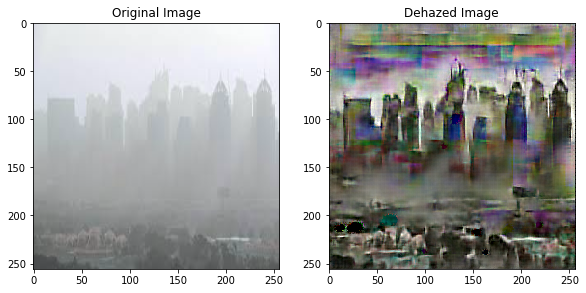

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


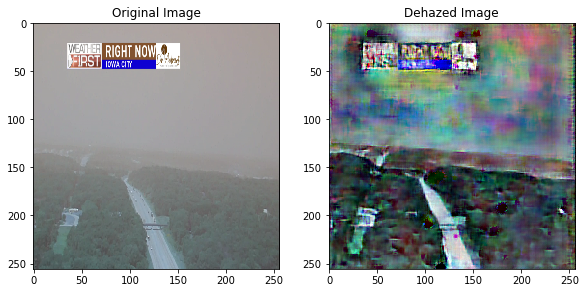

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


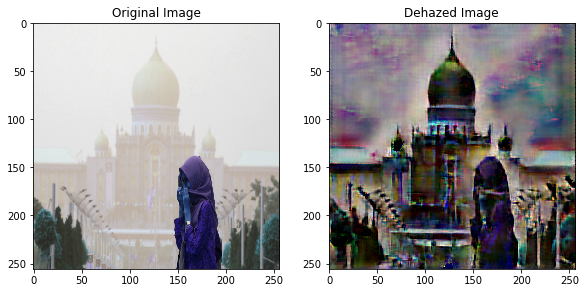

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


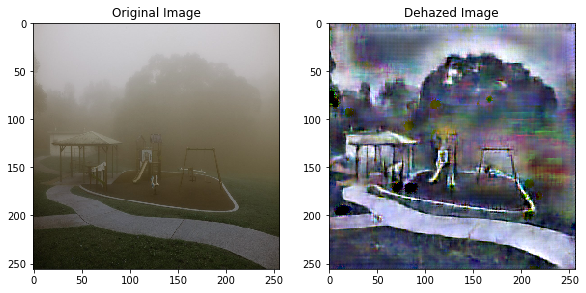

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


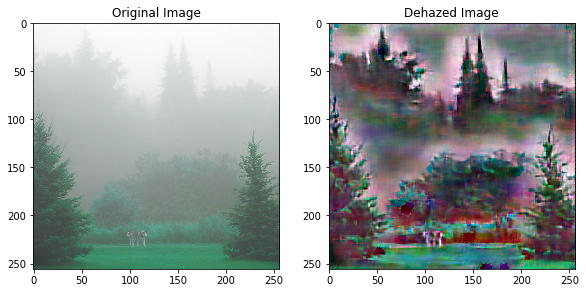

In [ ]:
for i in range(0,len(X_test_orig)):
    
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_test_orig[i])
    
    ax = plt.subplot(132)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

In [ ]:
X_test_orig = X_test_orig.numpy()
X_dehazed = X_dehazed.numpy()

X_test_orig=X_test_orig*255
X_dehazed=X_dehazed*255

ref_mat=X_test_orig
res_mat=X_dehazed

ref_mat = ref_mat.astype('float') / 255.0
res_mat = res_mat.astype('float') / 255.0

#PSNR
mean_psnr = mean_psnr_srgb(ref_mat, res_mat)
print('mean_psnr:')
print(mean_psnr)

# SSIM
mean_ssim = mean_ssim_srgb(ref_mat, res_mat)
print('mean_ssim:')
print(mean_ssim)

mean_psnr:
10.244191284684433
mean_ssim:
0.5378115434324828
